In [1]:
import gym
import time
import matplotlib.pyplot as plt
from pyswip import Prolog
from utils import create_level, define_reward, process_state, perform_action, show_match

In [2]:
H = 10
W = 10
NUM_EPISODES = 5
MAX_STEPS = 30
MONSTER = 'kobold'
WEAPON = 'tsurugi'
PATH = 'kb.pl'

In [3]:
des_file = create_level(width=W, height=H, monster=MONSTER, weapon=WEAPON)
reward_manager = define_reward()

In [4]:
env = gym.make('MiniHack-Skill-Custom-v0',
               character="sam-hum-neu-mal",
               observation_keys=('screen_descriptions','inv_strs','blstats','message','pixel'),
               des_file=des_file,
               reward_manager=reward_manager)

In [5]:
obs = env.reset()
env.render()


Konnichi wa Agent, welcome to NetHack!  You are a lawful male human Samurai.    
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                                                                
                                  .)...%....                                    
                                  ..........                                    
                                  ..........                                    
                                  ......@...                                    
                           

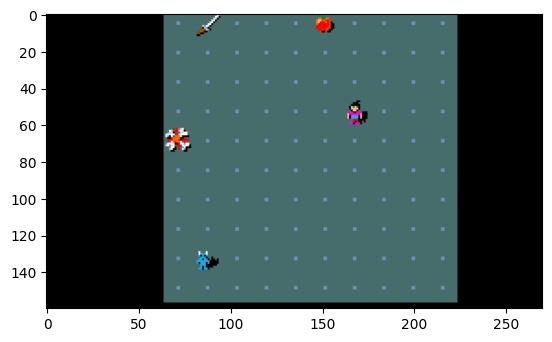

In [6]:
plt.imshow(obs['pixel'][115:275, 480:750])

Initialize the knowledge base.

In [7]:
KB = Prolog()
KB.consult(PATH)

#### Main code
- Perform `NUM_EPISODES` experiences in the environment.
- Use `Prolog` to define the axioms and choose the action to perform.
- The main goal is to _reach and eat_ the `apple`.

Episode 4 - 10 steps
End status: TASK_SUCCESSFUL
Final reward: 2.0
After 5 episodes, mean return is 2.0
The rewards of the episodes are: [2.0, 2.0, 2.0, 2.0, 2.0]


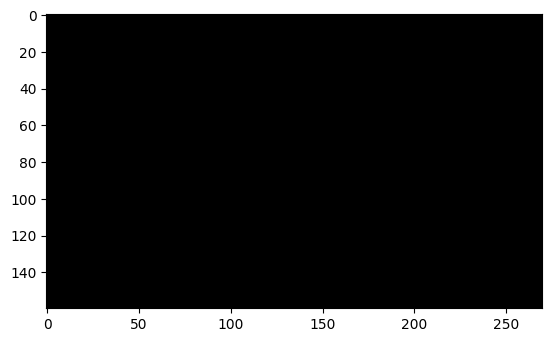

In [8]:
rewards = []
for episode in range(NUM_EPISODES):
    # count the number of steps of the current episode
    steps = 0
    # store the cumulative reward
    reward = 0.0
    # collect obs['pixel'] to visualize
    ep_states = []

    obs = env.reset()
    ep_states.append(obs['pixel'])
    done = False

    # Main loop
    while not done and steps < MAX_STEPS:
        # Get the observation from the env and assert the facts in the kb
        process_state(obs, KB, MONSTER, WEAPON)

        # Query Prolog
        # Run the inference and get the action to perform
        # Get the first answer from Prolog -> the top-priority action
        try:
            action = list(KB.query('action(X)'))[0]
            action = action['X']
            # print(f'>> Current action from Prolog: {action}')
        except Exception as e:
            action = None

        # Perform the action in the environment
        if action:
            obs, reward, done, info = perform_action(action, env)
            ep_states.append(obs['pixel'])
            # env.render()
        else:
            print("ERROR: impossible to perform any action. Please check assertions and definitions in KB.")
            break

        steps += 1

    # Display game with interface
    show_match(ep_states)
    # Print information about the ended episode
    print(f'Episode {episode} - {steps} steps')
    print(f'End status: {info["end_status"].name}')
    print(f'Final reward: {reward}')
    time.sleep(0.75)

    rewards.append(reward)

    # reset the environment and retract axioms that may cause errors
    obs = env.reset()
    KB.retractall('stepping_on(agent,_,_)')


print(f'After {NUM_EPISODES} episodes, mean return is {sum(rewards)/NUM_EPISODES}')
print("The rewards of the episodes are:", rewards)